In [ ]:
# augmenting the dataset the following data to create super rows
# - last 5 / 10 games PTS, REB, AST, MIN, FGA
# - home game flag
# - back-to-back flag
# - season-level stats (season averages, shooting %, etc.)

import pandas as pd
import numpy as np

# load per game data
games = pd.read_csv("../data/nba_games_with_travel.csv")

# load season data
season = pd.read_csv("../data/nba_player_stats_2016_2025.csv")

# sort data
games["GAME_DATE"] = pd.to_datetime(games["GAME_DATE"])
games = games.sort_values(["PLAYER_ID", "GAME_DATE"])

# get previous season label
def get_prev_season(season_label):
    year1 = int(season_label.split("-")[0])
    prev_year1 = year1 - 1
    prev_year2 = str((prev_year1 + 1) % 100).zfill(2)
    return f"{prev_year1}-{prev_year2}"

games["PREV_SEASON"] = games["SEASON_LABEL"].apply(get_prev_season)

# keep useful season columns
season_cols_useful = [
    "PLAYER_ID", "SEASON",
    "PTS", "REB", "AST", "MIN",
    "FG_PCT", "FG3_PCT", "FT_PCT"
]

# rename to not conflict with per game columns
season_stat = season[season_cols_useful].rename(columns={
    "PTS": "SEASON_PTS",
    "REB": "SEASON_REB",
    "AST": "SEASON_AST",
    "MIN": "SEASON_MIN",
    "FG_PCT": "SEASON_FG_PCT",
    "FG3_PCT": "SEASON_FG3_PCT",
    "FT_PCT": "SEASON_FT_PCT"
})

# merge to super row
df = games.merge(
    season_stat,
    left_on=["PLAYER_ID", "PREV_SEASON"],
    right_on=["PLAYER_ID", "SEASON"],
    how="left"
)
df = df.sort_values(["PLAYER_ID", "GAME_DATE"])

# calculate rolling stats
rolling_stats = ["PTS", "REB", "AST", "MIN", "FGA",
                 "FG_PCT", "FG3_PCT", "FT_PCT"]
for stat in rolling_stats:
    if stat not in df.columns:
        print(f"Warning: '{stat}' not in df.columns, skipping rolling features for it.")
        continue

    df[f"{stat}_LAST5"] = (
        df.groupby("PLAYER_ID")[stat]
          .rolling(5)
          .mean()
          .reset_index(0, drop=True)
    )
    df[f"{stat}_LAST10"] = (
        df.groupby("PLAYER_ID")[stat]
          .rolling(10)
          .mean()
          .reset_index(0, drop=True)
    )

# add home_game columns and b2b columns
df["HOME_GAME"] = df["MATCHUP"].str.contains("vs").astype(int)
df["BACK_TO_BACK"] = (df["DAYS_REST"] == 1).astype(int)

# delete NaN
df = df.fillna(0)

# save csv
df.to_csv("../data/final_dataset.csv", index=False)
print("final_dataset.csv created")
print("Shape:", df.shape)

final_dataset.csv created
Shape: (228435, 61)


In [2]:
from sklearn.model_selection import train_test_split

#load dataset
df = pd.read_csv("../data/final_dataset.csv")

features = [
    # last 5 and las 10
    "PTS_LAST5", "PTS_LAST10",
    "REB_LAST5", "REB_LAST10",
    "AST_LAST5", "AST_LAST10",
    "MIN_LAST5", "MIN_LAST10",
    "FGA_LAST5", "FGA_LAST10",
    "FG_PCT_LAST5", "FG_PCT_LAST10",
    "FG3_PCT_LAST5", "FG3_PCT_LAST10",
    "FT_PCT_LAST5", "FT_PCT_LAST10",

    # travel
    "DISTANCE_TRAVELED_KM",
    "DAYS_REST",
    "BACK_TO_BACK",
    "HOME_GAME",

    # season features
    "SEASON_PTS", "SEASON_REB", "SEASON_AST",
    "SEASON_MIN", "SEASON_FG_PCT",
    "SEASON_FG3_PCT", "SEASON_FT_PCT"
]


target = "PTS"

#make sure no NaN
df = df.dropna(subset=features + [target])

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=1
)



In [6]:
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

def evaluate_model(model, X_test, y_test, preds, feature_names):
    
    #metrics
    rmse = mean_squared_error(y_test, preds, squared=False)
    r2 = r2_score(y_test, preds)

    print("\nMODEL RESULTS")
    print(f"RMSE: {rmse:.3f}")
    print(f"R² Score: {r2:.3f}")

    # Convert to arrays for plotting
    y_true = np.array(y_test)
    y_pred = np.array(preds)


    plt.figure(figsize=(6,6))
    plt.scatter(y_true, y_pred, s=8, alpha=0.25)
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], color="red", lw=2)
    plt.title("Predicted vs Actual Points")
    plt.xlabel("Actual Points")
    plt.ylabel("Predicted Points")
    plt.grid(alpha=0.3)
    plt.show()


    errors = y_true - y_pred

    plt.figure(figsize=(7,4))
    plt.hist(errors, bins=40, color="skyblue", alpha=0.85)
    plt.title("Prediction Residuals (Actual − Predicted)")
    plt.xlabel("Error (Points)")
    plt.ylabel("Frequency")
    plt.grid(alpha=0.3)
    plt.show()

    return rmse, r2

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   46.0s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed: 14.8min finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.6s
[Parallel(n_jobs=20)]: Done 400 out of 400 | elapsed:    1.5s finished



MODEL RESULTS
RMSE: 5.095
R² Score: 0.644


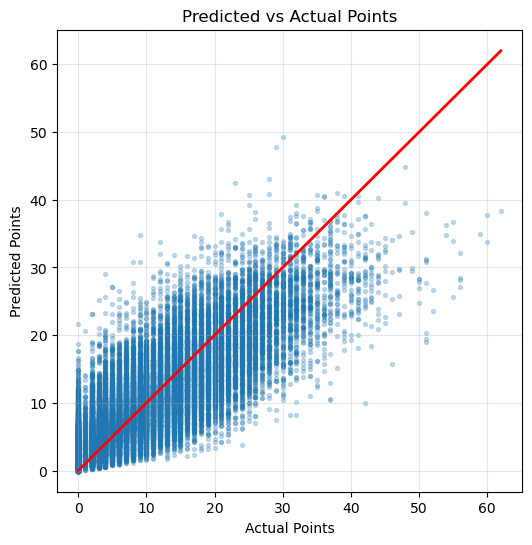

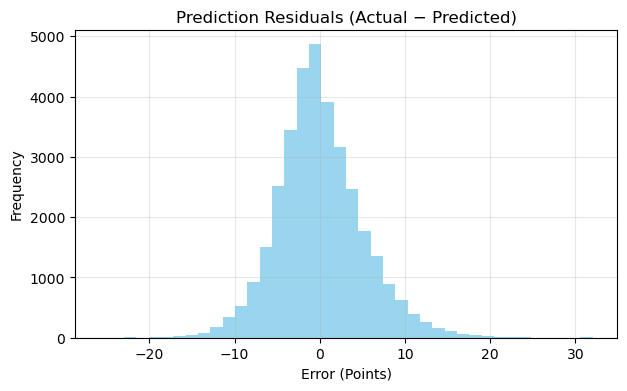

In [7]:
from sklearn.ensemble import RandomForestRegressor
# random forest method in the hw

rf_model = RandomForestRegressor(
    # number of trees
    n_estimators = 400,
    # tree max depth
    max_depth = 20,
    # n samples before splitting
    min_samples_split = 4,
    random_state = 1,
    verbose = 1,
    n_jobs=-1 # use all CPU for faster computation
)

rf_model.fit(X_train, y_train)
preds = rf_model.predict(X_test)

# print rmse, r2, and draw graph
rf_rmse, rf_r2 = evaluate_model(
    model = rf_model,
    X_test = X_test,
    y_test = y_test,
    preds = preds,
    feature_names = features
)


      Iter       Train Loss      OOB Improve   Remaining Time 
         1          69.4612           4.5010            7.81m
         2          65.3969           4.2155            8.45m
         3          61.4466           2.6661            8.29m
         4          58.2825           4.0996            8.58m
         5          54.9352           1.6718            8.40m
         6          52.5638           4.2155            8.30m
         7          49.9389           1.9207            8.45m
         8          47.7050           2.2660            8.30m
         9          45.7349           2.3032            8.36m
        10          43.8738           1.7730            8.28m
        20          32.6693           0.8175            8.14m
        30          28.4781           0.4542            7.94m
        40          26.7008          -0.6033            7.76m
        50          26.2832           0.7313            7.68m
        60          25.8194          -0.1462            7.47m
       

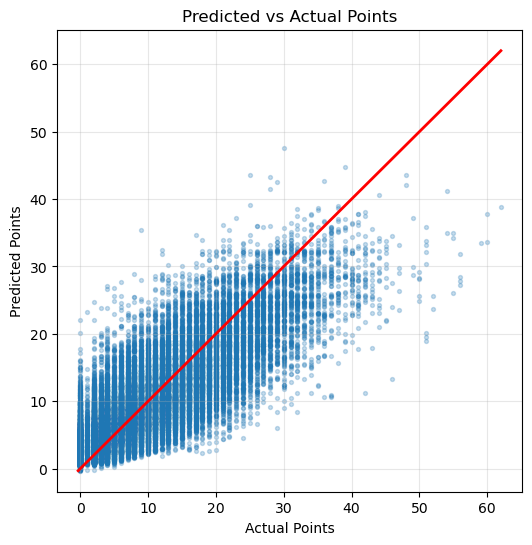

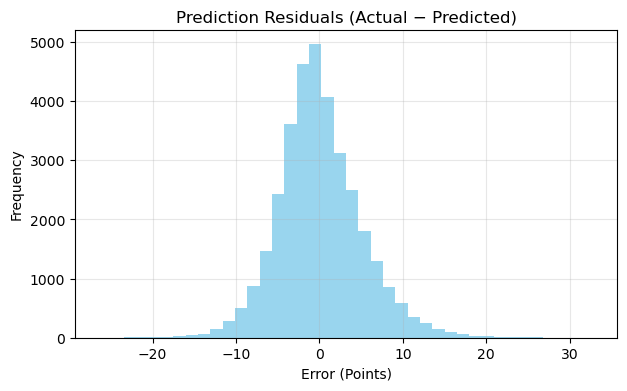

In [9]:
from sklearn.ensemble import GradientBoostingRegressor
# boosting tree method in the hw

gb_model = GradientBoostingRegressor(
    # number of trees
    n_estimators = 400,      
    learning_rate = 0.05,   
    max_depth = 3, 
    # use 80% of data per stage
    subsample = 0.8,        
    random_state = 1,
    verbose = 1
)

gb_model.fit(X_train, y_train)
gb_preds = gb_model.predict(X_test)

# print rmse, r2, and draw graph
gb_rmse, gb_r2 = evaluate_model(
    model = gb_model,
    X_test = X_test,
    y_test = y_test,
    preds = gb_preds,
    feature_names = features
)

Binning 0.038 GB of training data: 0.955 s
Binning 0.004 GB of validation data: 0.012 s
Fitting gradient boosted rounds:
[1/300] 1 tree, 31 leaves, max depth = 8, train loss: 34.53419, val loss: 35.02573, in 0.067s
[2/300] 1 tree, 31 leaves, max depth = 8, train loss: 32.42001, val loss: 32.86432, in 0.070s
[3/300] 1 tree, 31 leaves, max depth = 8, train loss: 30.51129, val loss: 30.91314, in 0.050s
[4/300] 1 tree, 31 leaves, max depth = 8, train loss: 28.78804, val loss: 29.14883, in 0.041s
[5/300] 1 tree, 31 leaves, max depth = 8, train loss: 27.23271, val loss: 27.56002, in 0.160s
[6/300] 1 tree, 31 leaves, max depth = 7, train loss: 25.82728, val loss: 26.12375, in 0.064s
[7/300] 1 tree, 31 leaves, max depth = 8, train loss: 24.55865, val loss: 24.82571, in 0.045s
[8/300] 1 tree, 31 leaves, max depth = 8, train loss: 23.41305, val loss: 23.65724, in 0.048s
[9/300] 1 tree, 31 leaves, max depth = 8, train loss: 22.37871, val loss: 22.59874, in 0.061s
[10/300] 1 tree, 31 leaves, max d

[86/300] 1 tree, 31 leaves, max depth = 8, train loss: 12.54651, val loss: 12.79257, in 0.039s
[87/300] 1 tree, 31 leaves, max depth = 8, train loss: 12.54312, val loss: 12.79199, in 0.028s
[88/300] 1 tree, 31 leaves, max depth = 8, train loss: 12.53989, val loss: 12.79045, in 0.038s
[89/300] 1 tree, 31 leaves, max depth = 8, train loss: 12.53659, val loss: 12.78989, in 0.030s
[90/300] 1 tree, 31 leaves, max depth = 8, train loss: 12.53323, val loss: 12.78955, in 0.034s
[91/300] 1 tree, 31 leaves, max depth = 8, train loss: 12.52971, val loss: 12.78916, in 0.028s
[92/300] 1 tree, 31 leaves, max depth = 8, train loss: 12.52628, val loss: 12.78791, in 0.029s
[93/300] 1 tree, 31 leaves, max depth = 8, train loss: 12.52359, val loss: 12.78741, in 0.029s
[94/300] 1 tree, 31 leaves, max depth = 8, train loss: 12.52071, val loss: 12.78705, in 0.029s
[95/300] 1 tree, 31 leaves, max depth = 8, train loss: 12.51787, val loss: 12.78737, in 0.025s
[96/300] 1 tree, 31 leaves, max depth = 8, train l

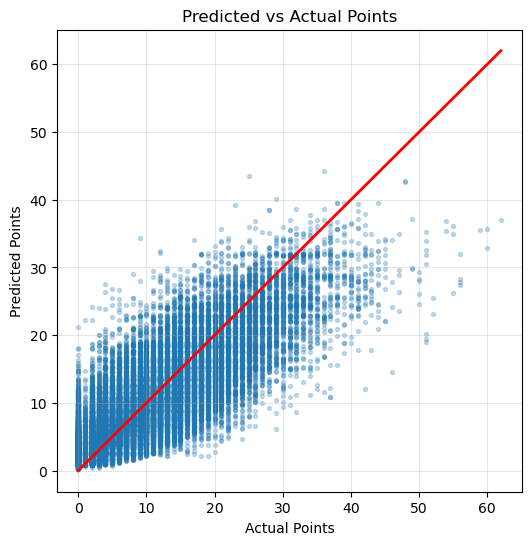

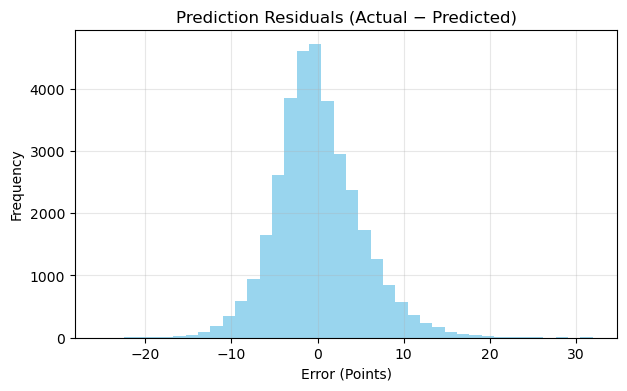

In [11]:
from sklearn.ensemble import HistGradientBoostingRegressor
# another regressor from ensemble

hgb_model = HistGradientBoostingRegressor(
    learning_rate = 0.05,
    max_depth = 8,
    max_iter = 300,      
    random_state = 1,
    verbose = 1
)

hgb_model.fit(X_train, y_train)
hgb_preds = hgb_model.predict(X_test)

hgb_rmse, hgb_r2 = evaluate_model(
    model = hgb_model,
    X_test = X_test,
    y_test = y_test,
    preds = hgb_preds,
    feature_names = features
)




MODEL RESULTS
RMSE: 5.223
R² Score: 0.626


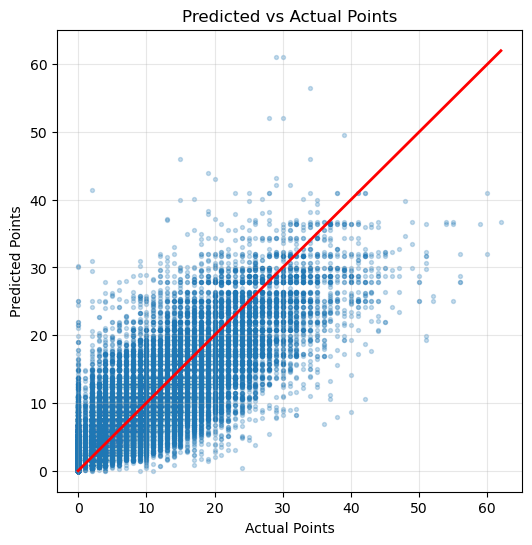

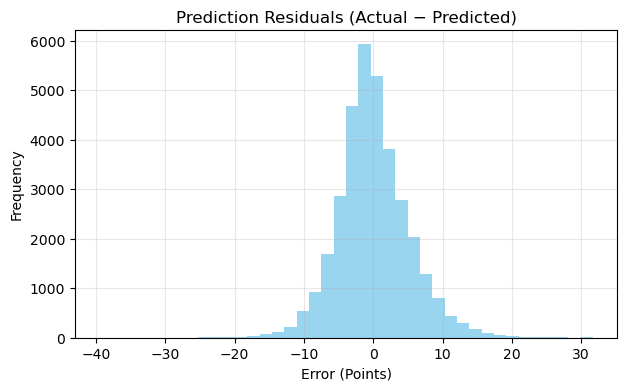

In [12]:
from sklearn.tree import DecisionTreeRegressor
# decision tree from hw

dt_model = DecisionTreeRegressor(
    max_depth = 12,
    min_samples_split = 10,
    random_state = 1
)

dt_model.fit(X_train, y_train)
dt_preds = dt_model.predict(X_test)

dt_rmse = mean_squared_error(y_test, dt_preds, squared=False)
dt_r2 = r2_score(y_test, dt_preds)


dt_rmse, dt_r2 = evaluate_model(
    model = dt_model,
    X_test = X_test,
    y_test = y_test,
    preds = dt_preds,
    feature_names = features
)
